In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import random
from transformers import BertTokenizer, BertModel
import json
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
torch.manual_seed(1)

In [4]:
device = "cpu"

In [20]:
#check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

#### Data Loading

In [6]:
train_data = json.load(open('../Dataset/NER_train.json', 'r'))
test_data = json.load(open('../Dataset/NER_test.json', 'r'))
val_data = json.load(open('../Dataset/NER_val.json', 'r'))

In [7]:
word_to_idx = {}

for case in train_data:
    for text in train_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

for case in test_data:
    for text in test_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

for case in val_data:
    for text in val_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

In [8]:
tag_to_ix = {}

for case in train_data:
    for tag in train_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

for case in test_data:
    for tag in test_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

for case in val_data:
    for tag in val_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

tag_to_ix['START_TAG'] = len(tag_to_ix)
tag_to_ix['END_TAG'] = len(tag_to_ix)

#### Bert Embeddings

In [9]:
# tokenizer = BertTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')
# bert_model = BertModel.from_pretrained('nlpaueb/legal-bert-base-uncased')

In [10]:
# embedding_mat = np.zeros((len(word_to_idx), 768))

# for word, idx in tqdm(word_to_idx.items()):
#     # if word in tokenizer.vocab:
#     #     embedding_mat[idx] = bert_model(tokenizer.encode(word))[1].detach().numpy()
#     # else:
#     #     embedding_mat[idx] = np.random.rand(768)
#     try:
#         tokens = tokenizer.batch_encode_plus([word], return_tensors='pt', add_special_tokens=False)
#     except:
#         tokens = tokenizer.batch_encode_plus(['unk'], return_tensors='pt', add_special_tokens=False)
#         continue
#     embeddings = None
#     with torch.no_grad():
#         # outputs = bert_model(**tokens)
#         # embeddings = outputs.last_hidden_state
#         try:
#             outputs = bert_model(**tokens)
#             embeddings = outputs.last_hidden_state
#         except:
#             tokens = tokenizer.batch_encode_plus(['unk'], return_tensors='pt', add_special_tokens=False)
#             outputs = bert_model(**tokens)
#             embeddings = outputs.last_hidden_state
#     embeddings = embeddings.squeeze(0)
#     word_embeddings = embeddings.mean(dim = 0)
#     embedding_mat[idx] = word_embeddings.squeeze(0).numpy()

In [11]:
# pickle.dump(embedding_mat, open('Word Embeddings/legal_bert_embedding_mat.pkl', 'wb'))

#### RNN model

In [21]:
class RNN_model(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, target_size, embedding_mat, start_tag, end_tag, tag_to_ix, device='cpu'):
        super(RNN_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_mat), freeze=False).to(device)
        self.rnn = nn.RNN(embedding_dim, hidden_dim).to(device)
        self.hidden2tag = nn.Linear(hidden_dim, target_size).to(device)
        self.start_tag = start_tag
        self.end_tag = end_tag
        self.tag_to_ix = tag_to_ix
        self.target_size = target_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        rnn_out, _ = self.rnn(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(rnn_out.view(len(sentence), -1))
        tag_scores = nn.functional.log_softmax(tag_space, dim=1)
        return tag_scores


In [9]:
bert_embeddings = pickle.load(open('../Part 3/legal_bert_embedding_mat.pkl', 'rb'))

In [24]:
rnn_model = RNN_model(len(word_to_idx), 768, 768, len(tag_to_ix), bert_embeddings, tag_to_ix['START_TAG'], tag_to_ix['END_TAG'], tag_to_ix).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(rnn_model.parameters(), lr=0.01)

epochs = 10
train_loss = []
val_loss = []
train_f1 = []
val_f1 = []

for epoch in tqdm(range(epochs)):
    loss = 0
    f1 = 0
    print(f'Epoch {epoch}')
    rnn_model.train()
    for case in train_data:
        sentence = prepare_sequence(train_data[case]['text'].split(' '), word_to_idx).to(device)
        targets = prepare_sequence(train_data[case]['labels'], tag_to_ix).to(device)
        rnn_model.zero_grad()
        tag_scores = rnn_model(sentence)
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        pred = torch.argmax(tag_scores, dim=1).cpu().detach().numpy()
        f1 += f1_score(targets.cpu().detach().numpy(), pred, average='macro')
    train_loss.append(loss/len(train_data))
    train_f1.append(f1/len(train_data))
    with torch.no_grad():
        rnn_model.eval()
        loss = 0
        f1 = 0
        for case in val_data:
            sentence = prepare_sequence(val_data[case]['text'].split(' '), word_to_idx).to(device)
            targets = prepare_sequence(val_data[case]['labels'], tag_to_ix).to(device)
            tag_scores = rnn_model(sentence)
            loss = loss_function(tag_scores, targets)
            loss += loss.item()
            pred = torch.argmax(tag_scores, dim=1).cpu().detach().numpy()
            f1 += f1_score(targets.cpu().detach().numpy(), pred, average='macro')
        val_loss.append(loss/len(val_data))
        val_f1.append(f1/len(val_data))

    print(f'Train loss: {train_loss[-1]}, Val loss: {val_loss[-1]}')
    print(f'Train macro f1: {train_f1[-1]}, Val macro f1: {val_f1[-1]}')
    print(f'Epoch {epoch + 1}/{epochs} done')



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0


 10%|█         | 1/10 [01:45<15:45, 105.10s/it]

Train loss: 0.00014239901793189347, Val loss: 0.00011826030822703615
Train macro f1: 0.42938328774026185, Val macro f1: 0.4403929611699275
Epoch 1/10 done
Epoch 1


 20%|██        | 2/10 [03:03<11:53, 89.16s/it] 

Train loss: 9.981796029023826e-05, Val loss: 7.733015081612393e-05
Train macro f1: 0.47516732306049875, Val macro f1: 0.4912687273390197
Epoch 2/10 done
Epoch 2


 30%|███       | 3/10 [05:11<12:31, 107.30s/it]

Train loss: 7.261287828441709e-05, Val loss: 4.676380194723606e-05
Train macro f1: 0.5385674607956337, Val macro f1: 0.5476723356682539
Epoch 3/10 done
Epoch 3


 40%|████      | 4/10 [07:31<11:58, 119.82s/it]

Train loss: 7.181614637374878e-05, Val loss: 3.114703213213943e-05
Train macro f1: 0.5828868968749258, Val macro f1: 0.5830083906989021
Epoch 4/10 done
Epoch 4


 50%|█████     | 5/10 [09:30<09:59, 119.84s/it]

Train loss: 7.422484486596659e-05, Val loss: 2.3208729544421658e-05
Train macro f1: 0.6095635543157208, Val macro f1: 0.6007558418730384
Epoch 5/10 done
Epoch 5


 60%|██████    | 6/10 [11:38<08:10, 122.55s/it]

Train loss: 7.575820927741006e-05, Val loss: 1.9082184735452756e-05
Train macro f1: 0.6293141632617083, Val macro f1: 0.6167578128938711
Epoch 6/10 done
Epoch 6


 70%|███████   | 7/10 [13:51<06:17, 125.89s/it]

Train loss: 7.701861613895744e-05, Val loss: 1.6193798728636466e-05
Train macro f1: 0.6457674492250092, Val macro f1: 0.6318150184148655
Epoch 7/10 done
Epoch 7


 80%|████████  | 8/10 [16:09<04:19, 129.84s/it]

Train loss: 7.559982623206452e-05, Val loss: 1.2655530554184224e-05
Train macro f1: 0.6621520426044659, Val macro f1: 0.6438319864411753
Epoch 8/10 done
Epoch 8


 90%|█████████ | 9/10 [18:27<02:12, 132.28s/it]

Train loss: 7.836481381673366e-05, Val loss: 1.1128609912702814e-05
Train macro f1: 0.6753839435723308, Val macro f1: 0.652106037085688
Epoch 9/10 done
Epoch 9


100%|██████████| 10/10 [20:50<00:00, 125.06s/it]

Train loss: 7.710643694736063e-05, Val loss: 8.814423381409142e-06
Train macro f1: 0.6755786525058232, Val macro f1: 0.6551314629647695
Epoch 10/10 done


In [26]:
torch.save(rnn_model, 'Models/rnn/10_epochs_legalbert.pt')

In [27]:
pickle.dump(train_loss, open('Losses/rnn/10_epochs_train_loss.pkl', 'wb'))
pickle.dump(val_loss, open('Losses/rnn/10_epochs_val_loss.pkl', 'wb'))
pickle.dump(train_f1, open('Macro_F1/rnn/10_epochs_train_f1.pkl', 'wb'))
pickle.dump(val_f1, open('Macro_F1/rnn/10_epochs_val_f1.pkl', 'wb'))

In [28]:
train_loss = pickle.load(open('Losses/rnn/10_epochs_train_loss.pkl', 'rb'))
val_loss = pickle.load(open('Losses/rnn/10_epochs_val_loss.pkl', 'rb'))
train_macro_f1 = pickle.load(open('Macro_F1/rnn/10_epochs_train_macro_f1.pkl', 'rb'))
val_macro_f1 = pickle.load(open('Macro_F1/rnn/10_epochs_val_macro_f1.pkl', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'Macro_F1/rnn/10_epochs_train_macro_f1.pkl'

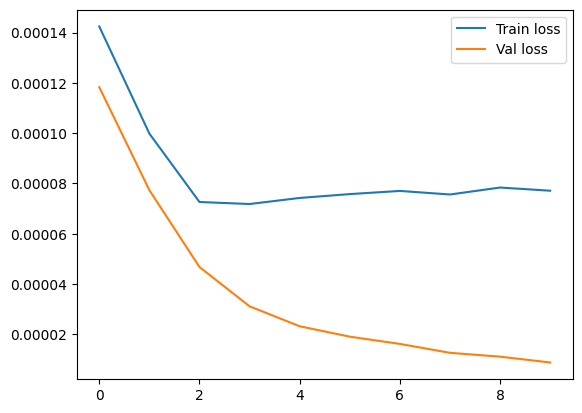

In [29]:
train_loss = [i.item() for i in train_loss]
val_loss = [i.item() for i in val_loss]

plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.show()

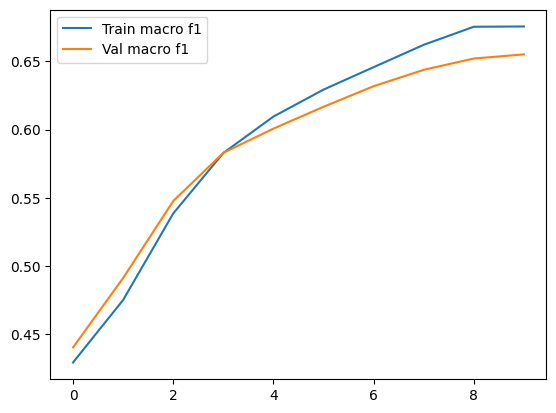

In [31]:
train_f1 = [i.item() for i in train_f1]
val_f1 = [i.item() for i in val_f1]

plt.plot(train_f1, label='Train macro f1')
plt.plot(val_f1, label='Val macro f1')
plt.legend()
plt.show()

In [37]:
model = torch.load('Models/rnn/10_epochs_legalbert.pt')

In [41]:
model.eval()
with torch.no_grad():
    f1 = 0
    for case in test_data:
        sentence = prepare_sequence(test_data[case]['text'].split(' '), word_to_idx)
        tags = prepare_sequence(test_data[case]['labels'], tag_to_ix)
        sentence = sentence.to(device)
        tags = tags.to(device)
        preds = model(sentence)
        preds = torch.argmax(preds, dim=1)
        tags = tags.cpu().numpy()
        preds = preds.cpu().numpy()
        f1 += f1_score(tags, preds, average='macro')
    print(f'Test macro f1: {f1/len(test_data)}')

Test macro f1: 0.6688873319144167
